# <u>S</u>tabilizer <u>S</u>ub<u>S</u>pace (S3) Projections

A library providing the necessary functionality to perform stabilizer subspace projections over systems of Pauli 
operators.

This facilitates implementations of qubit reduction techniques such as [*tapering*](https://arxiv.org/abs/1701.08213) and [*Contextual-Subspace VQE*](https://doi.org/10.22331/q-2021-05-14-456), both of which are demonstrated here.

In [1]:
from qreduce.tapering import tapering
from qreduce.cs_vqe import cs_vqe
import qreduce.utils.qonversion_tools as qonvert
from qreduce.utils.operator_toolkit import exact_gs_energy, plot_ground_state_amplitudes

import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf
from itertools import combinations
import json
import numpy as np

First of all, we construct our molecular Hamiltonian:

Amplitude histogram for the ground state of the full system:


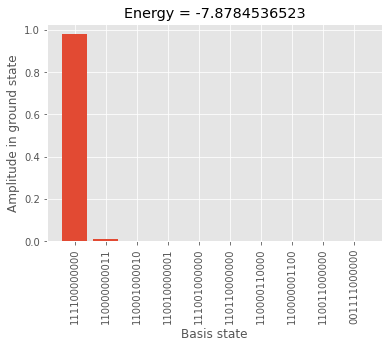

In [2]:
# Set molecule parameters
geometry = [('Li', (0.0, 0.0, 0.0)), 
            ('H', (1.4, 0.0, 0.0))]#, 
            #('H', (0.0, 1.0, 0.0))]
basis = 'sto-3g'
multiplicity = 1
charge = 0

# Perform electronic structure calculations and
# obtain Hamiltonian as an InteractionOperator
hamiltonian = ofpyscf.generate_molecular_hamiltonian(
    geometry, basis, multiplicity, charge)

# Convert to a FermionOperator
hamiltonian_ferm_op = of.get_fermion_operator(hamiltonian)

#Convert to a QubitOperator via Jordan-Wigner and convert to dictionary representation {Pauli:coeff, ...}
hamiltonian_jw = of.jordan_wigner(hamiltonian_ferm_op)
n_qubits = hamiltonian.n_qubits
ham_dict = qonvert.QubitOperator_to_dict(hamiltonian_jw, hamiltonian.n_qubits)

#print('Jordan-Wigner Hamiltonian:\n\n', ham_dict)
print('Amplitude histogram for the ground state of the full system:')
amps, true_gs = plot_ground_state_amplitudes(ham_dict, n_qubits, return_amps=True)

Perform qubit tapering to reduce the number of necessary qubits:

In [3]:
taper_hamiltonian = tapering(hamiltonian=ham_dict, 
                               ref_state=[int(i) for i in amps[0][0]])
ham_tap = taper_hamiltonian.taper_it()
tap_gs_energy, tap_gs = exact_gs_energy(ham_tap._dict)

print(f'In the sector {taper_hamiltonian.symmetry_sec}, we find the ground state energy to be {tap_gs_energy}.')
print(f'The absolute error is {tap_gs_energy-true_gs}.')

In the sector [1, 1, 1, 1], we find the ground state energy to be -7.878453652277155.
The absolute error is -1.3322676295501878e-14.


Build CS-VQE model with legacy code for comparison:

In [4]:
from qreduce.utils.cs_vqe_tools_legacy import csvqe_approximations_heuristic, quasi_model, greedy_dfs

ham = ham_tap._dict
terms_noncon = greedy_dfs(ham, cutoff=5)[-1]
ham_noncon = {op:ham[op] for op in terms_noncon}
n_qubits = ham_tap.n_qbits

csvqe = csvqe_approximations_heuristic(ham, 
                                       ham_noncon, 
                                       n_qubits, 
                                       tap_gs_energy)

print('CS-VQE errors:', list(zip(range(n_qubits+1), csvqe[2])), '\n')
print('chosen order:', csvqe[3])

CS-VQE errors: [(0, 0.017914991256460233), (1, 0.017914991256454016), (2, 0.005163143591193631), (3, 0.0035356177854639625), (4, 0.001452160458777385), (5, 0.0008280389992059156), (6, 0.00022299912576961844), (7, 0.00016863012215750928), (8, 2.042810365310288e-14)] 

chosen order: [6, 7, 3, 2, 5, 4, 0, 1]


# Contextual-Subspace VQE
Here we run through the basic CS-VQE functionality...

When the `cs_vqe` class is initiated it generates a set of stabilizers defined through the CS-VQE method. These stabilizers are consistent with the noncontextual ground state energy, a classical estimate of the true value that is *at least as accurate* as Hartree-Fock.

In [5]:
cs = cs_vqe(ham, noncontextual_set=terms_noncon)

#match_original = abs(cs.ngs_energy-gs_noncon[0])<1e-13
print("Noncontextual GS energy:",  cs.ngs_energy)#, ' // matches original?', match_original)

print("Symmetry generators:    ", cs.generators)
print("Clique representatives: ", cs.cliquereps)
print("Generator eigenvalues:  ", cs.nu)
print("Clique operator coeffs: ", cs.r)

Noncontextual GS energy: -7.860538661020698
Symmetry generators:     ['ZIIIIIII', 'ZIZIZZZI', 'IZIZZZIZ', 'IIZIIIII', 'IIIZZZIZ', 'IIIIZZIZ', 'IIIIIZIZ', 'IIIIIIIZ']
Clique representatives:  ['ZIIIIIII', 'YZZZIIYI']
Generator eigenvalues:   [ 1 -1 -1  1  1  1  1  1]
Clique operator coeffs:  [-1.00000000e+00  9.29585463e-08]


In [6]:
all([G in cs.noncontextual_set for G in cs.generators])

False

In [7]:
chemaccnumq = list(np.array(csvqe[2])<0.0016).index(True) #mol['chem_acc_num_q']

#exact, gs = exact_gs_energy(cs.hamiltonian)
print('Exact energy:',true_gs)
print('Noncon error:', cs.ngs_energy-true_gs)
print(f'Target_error for {chemaccnumq} qubits:', csvqe[2][chemaccnumq])# exact_gs_energy(mol['ham_reduced'][num_sim_q])[0]-exact)

Exact energy: -7.878453652277142
Noncon error: 0.017914991256444246
Target_error for 4 qubits: 0.001452160458777385


**CS-VQE is sensitive to the choice of stabilizers we wish to enforce.**

Below, we drop stabilizer constraints iteratively, choosing that which minimizes the energy at each step.

In [8]:
stab_index_pool = list(range(len(cs.generators)))

optimal_errors = {}
for num_sim_q in range(2,cs.n_qubits):
    cs_vqe_errors = []
    for order in combinations(range(len(cs.generators)), cs.n_qubits - num_sim_q):
        order = list(order)
        ham_cs = cs.contextual_subspace_hamiltonian(stabilizer_indices=order)#list(range(cs_vqe_mol.num_qubits)),
                                                                    #projection_qubits=order)
        cs_energy, cs_vector = exact_gs_energy(ham_cs)
        cs_vqe_errors.append((cs_energy-true_gs, order))
        
    cs_vqe_errors = sorted(cs_vqe_errors, key=lambda x:x[0])
    error, stab_index_pool = cs_vqe_errors[0]
    
    optimal_errors[num_sim_q]={}
    optimal_errors[num_sim_q]['error'] = error
    optimal_errors[num_sim_q]['stab_indices'] = list(stab_index_pool)
    
for num_sim_q in optimal_errors:
    error = optimal_errors[num_sim_q]['error']
    diff_will = error-csvqe[2][num_sim_q]
    print(diff_will)
    stab_indices = optimal_errors[num_sim_q]['stab_indices']
    print(f'Performing {num_sim_q}-qubit CS-VQE, we may obtain',
          f'an absolute error of {error:.8f},\n',
          f'enforcing the stabilizers {stab_indices}, {[cs.generators[i] for i in stab_indices]}\n'
         )

0.01112406467214111
Performing 2-qubit CS-VQE, we may obtain an absolute error of 0.01628721,
 enforcing the stabilizers [1, 2, 3, 5, 6, 7], ['ZIZIZZZI', 'IZIZZZIZ', 'IIZIIIII', 'IIIIZZIZ', 'IIIIIZIZ', 'IIIIIIIZ']

0.011847894675989679
Performing 3-qubit CS-VQE, we may obtain an absolute error of 0.01538351,
 enforcing the stabilizers [1, 2, 3, 6, 7], ['ZIZIZZZI', 'IZIZZZIZ', 'IIZIIIII', 'IIIIIZIZ', 'IIIIIIIZ']

0.01306797136836746
Performing 4-qubit CS-VQE, we may obtain an absolute error of 0.01452013,
 enforcing the stabilizers [1, 2, 3, 7], ['ZIZIZZZI', 'IZIZZZIZ', 'IIZIIIII', 'IIIIIIIZ']

0.0013088819191366952
Performing 5-qubit CS-VQE, we may obtain an absolute error of 0.00213692,
 enforcing the stabilizers [1, 2, 3], ['ZIZIZZZI', 'IZIZZZIZ', 'IIZIIIII']

2.3424009398809176e-08
Performing 6-qubit CS-VQE, we may obtain an absolute error of 0.00022302,
 enforcing the stabilizers [1, 2], ['ZIZIZZZI', 'IZIZZZIZ']

1.3644112506483452e-08
Performing 7-qubit CS-VQE, we may obtain an ab

Suppose we have access to just 3 qubits on some quantum device... then we may construct the corresponding 3-qubit CS-VQE model, obtaining the reduced Hamiltonian, Ansatz operator and noncontextual reference state.

In [9]:
num_sim_q = 3
stab_indices = optimal_errors[num_sim_q]['stab_indices']
ham_cs = cs.contextual_subspace_hamiltonian(stabilizer_indices=stab_indices)
anz_cs = cs._contextual_subspace_projection(operator=ansatz,stabilizer_indices=stab_indices)
ngs = cs.noncontextual_ground_state(stabilizer_indices=stab_indices)

NameError: name 'ansatz' is not defined

In [ ]:
print('Reduced Hamiltonian:\n', ham_cs)
print('\nReduced Ansatz:\n', anz_cs)
print('\nReference state:', ngs)

In [ ]:
plot_ground_state_amplitudes(operator=ham_cs, num_qubits=num_sim_q)#, reverse_bitstrings=True)

## Running CS-VQE

Finally, we may perform a VQE routine taking as input the reduced Hamiltonian and Ansatz defined above.

In [ ]:
import warnings; warnings.filterwarnings("ignore", category=DeprecationWarning)
import qreduce.utils.circuit_tools as circ
import qreduce.utils.circuit_execution_tools as circ_ex
from qiskit.circuit import QuantumCircuit

In [ ]:
qc = QuantumCircuit(num_sim_q)
for index, bit in enumerate(ngs):
    q_pos = num_sim_q-1-index
    if int(bit)==1:
        qc.x(q_pos)

qc = circ.circ_from_paulis(circ=qc, paulis=list(anz_cs.keys()), trot_order=2)
circ.cancel_pairs(circ=qc, hit_set={'s', 'sdg'})
circ.cancel_pairs(circ=qc, hit_set={'h', 'h'})
bounds = np.array([(a-np.pi/2, a+np.pi/2) for a in anz_cs.values()]) # optimization bounds
qc.parameter_bounds = bounds

qc.draw(output='mpl')

In [ ]:
vqe_result = circ_ex.vqe_simulation(ansatz=qc, operator=ham_cs, init_params=np.array(list(anz_cs.values())))

In [ ]:
log_errors = np.log10(np.square(np.array(vqe_result['values'])-exact))
plt.plot(log_errors, color='black', label='Optimizer output')
plt.hlines(np.log10(0.0016**2), 0, vqe_result['counts'][-1], label='Chemical accuracy', color='green')
plt.legend()